In [30]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *
from gridsearch import grid_search

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [31]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

### Separating training set and test set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

### Rescaling the output to the [0,1] range

In [4]:
from sklearn.preprocessing import MinMaxScaler

rescaler = MinMaxScaler()
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
rescaler.fit(y_train)
y_train = rescaler.transform(y_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

Combination: [512, 128, 3] ReLU Fan_in (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.9) 0.0005


Epochs:  13%|█▎        | 1288/10000 [16:06<1:49:00,  1.33it/s]


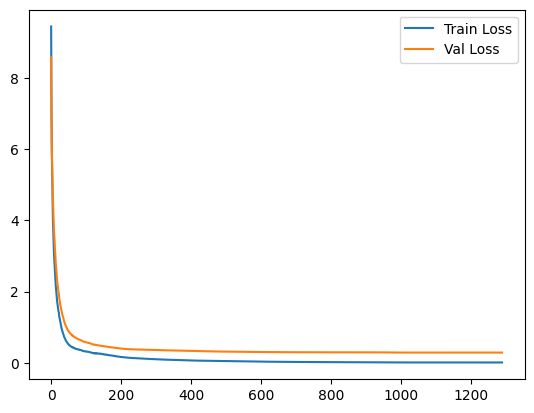

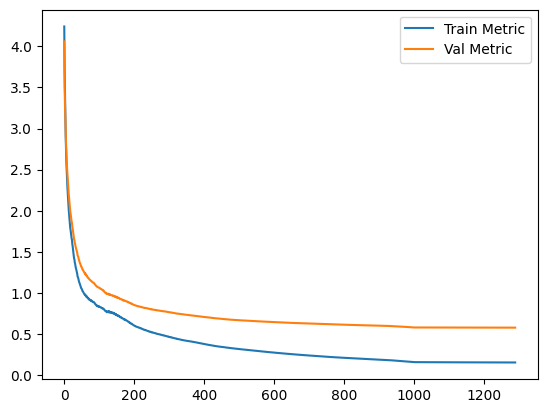

Fold 1 of 6 completed
Train Loss: 0.011699017033468715
Train Metric: 0.1617817744133571
Val Loss: 0.29035486777112945
Val Metric: 0.583574785138115


Epochs:  13%|█▎        | 1256/10000 [12:19<1:25:46,  1.70it/s]


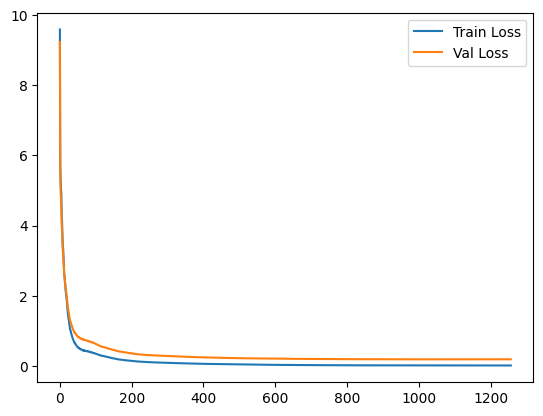

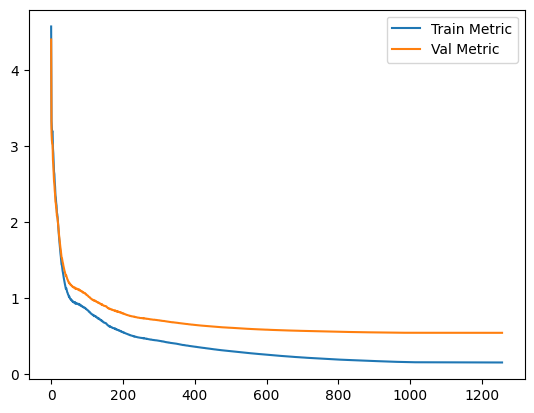

Fold 2 of 6 completed
Train Loss: 0.011387159352028081
Train Metric: 0.16408292674092534
Val Loss: 0.18579855212566712
Val Metric: 0.5466219320673241


Epochs:  13%|█▎        | 1252/10000 [07:38<53:21,  2.73it/s]  


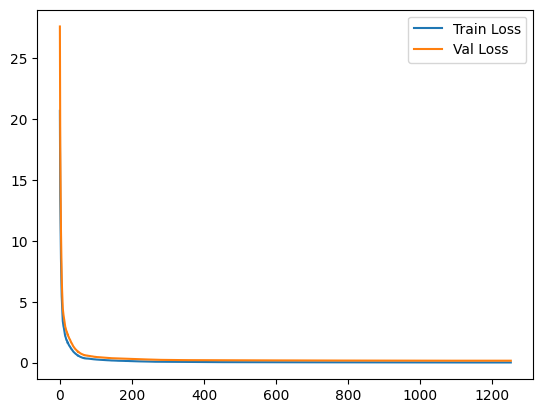

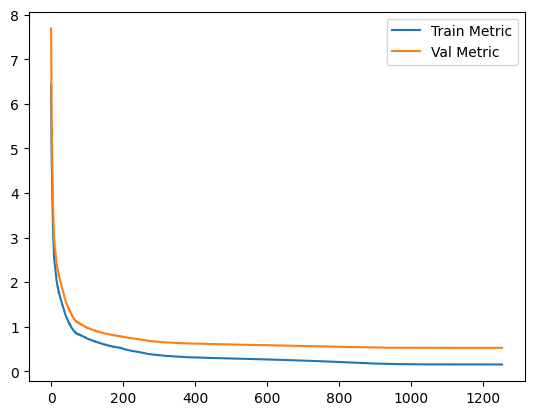

Fold 3 of 6 completed
Train Loss: 0.011363746040494654
Train Metric: 0.16193816768477065
Val Loss: 0.1556827430147329
Val Metric: 0.52774810503088


Epochs:  13%|█▎        | 1298/10000 [06:49<45:44,  3.17it/s] 


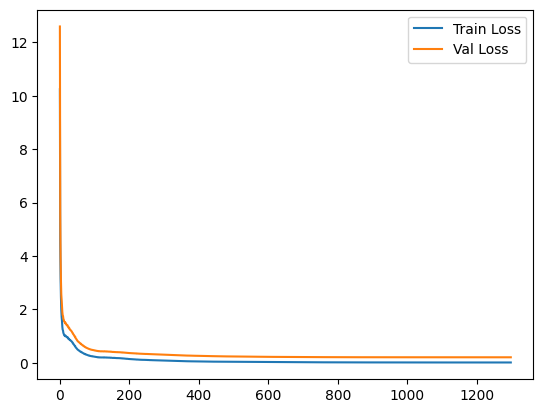

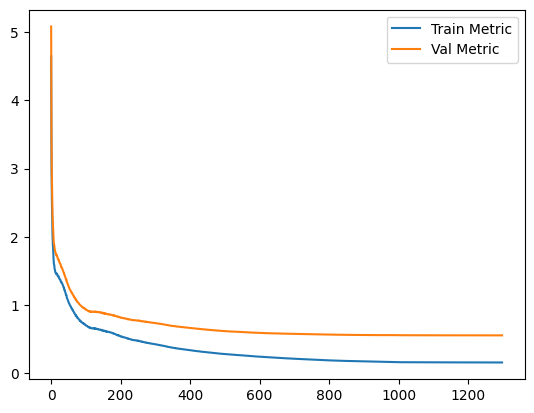

Fold 4 of 6 completed
Train Loss: 0.011832316011260386
Train Metric: 0.16354488196740954
Val Loss: 0.2066245057021292
Val Metric: 0.5589147515032735


Epochs:  13%|█▎        | 1270/10000 [06:52<47:14,  3.08it/s]  


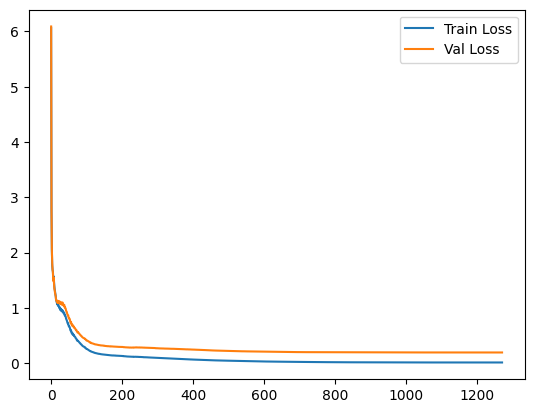

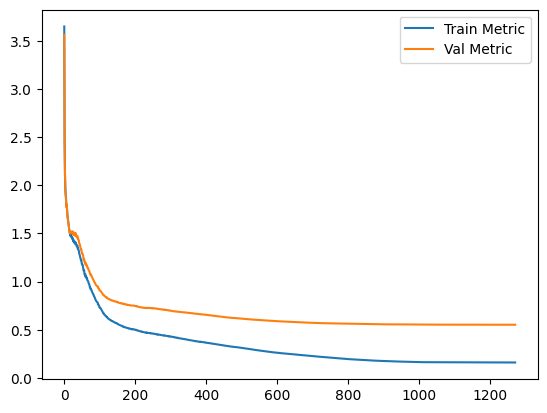

Fold 5 of 6 completed
Train Loss: 0.011986264125879064
Train Metric: 0.16584794241126305
Val Loss: 0.1936240135086488
Val Metric: 0.5544500087292529


Epochs:  13%|█▎        | 1276/10000 [08:06<55:25,  2.62it/s]  


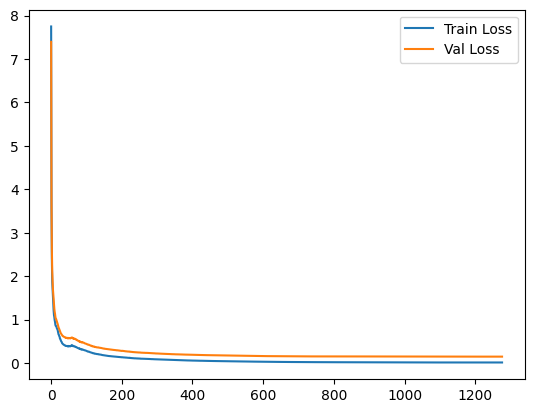

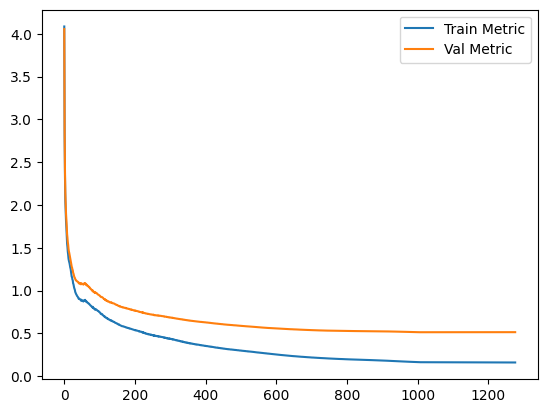

Fold 6 of 6 completed
Train Loss: 0.01244061073433047
Train Metric: 0.16857583873145512
Val Loss: 0.14648231582247545
Val Metric: 0.51685109080307
Combination: [512, 128, 3] ReLU Fan_in (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.9) 0.0005
Statistics: {'tr_loss': 0.011784852216243558, 'tr_metric': 0.16429525532486347, 'val_loss': 0.19642783299079716, 'val_metric': 0.5480267788786526}






In [33]:
hyperparameters = {
    'layers_sizes': [[512, 128, 3]],
    'activations': ["ReLU"], 
    'startings': ["Fan_in"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-8],
    'momentums': [('Nesterov', 0.9)],
    'etas': [5e-4],
}

data_to_csv = grid_search(
    hyperparams=hyperparameters,
    X=X_train,
    y=y_train,
    k=6,
    metric=MEE(),
    loss=MSE(1),
    seed=6,
    verbose=True
)

In [ ]:
# reshape ytrain eliminating last shape
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_train.shape

In [ ]:
# reshape Xtrain eliminating last shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_train.shape

In [ ]:
# use scikit-lear to make regression in 3d
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32,32),
    activation='relu',
    solver='sgd',
    alpha=0,
    batch_size=1,
    learning_rate_init=1e-3,
    max_iter=2500,
    shuffle=True,
    random_state=6,
    verbose=True,
    momentum=0,
    beta_1= 0,
    beta_2= 0.,
    epsilon= 1,
    validation_fraction = 0,
    nesterovs_momentum=False
)

mlp.fit(X_train, y_train)
# print the learning curve
plt.plot(mlp.loss_curve_)
plt.show()

# print the mean error
print(MEE()(y_train, mlp.predict(X_train)))

In [34]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    